**목차:**

1.   housing 데이터 로드 및 테스트셋 생성
2.   데이터 시각화
3.   데이터 준비와 전처리
4.   모델 선택과 훈련
5.   모델 평가와 그리드 서치
6.   실습 과제



In [ ]:
# imports and setups
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


# 실행 결과를 일정하게 유지하기 위해 랜덤 시드를 설정:
np.random.seed(42)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=12)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
np.set_printoptions(precision=2, suppress=True)

## 1. California Housing Prices 데이터 로드 및 테스트셋 생성


**데이터셋**:
- StatLib 에서 제공하는 [캘리포니아 주택 가격 데이터셋](https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html)을 사용
- 이 데이터셋은 1990년 캘리포니아 인구 조사 데이터를 기반

**과제 정의**:
- 캘리포니아 인구 조사 데이터를 사용해 주택 가격 모델을 구축
- 캘리포니아의 각 블록 그룹에 대한 인구, 중위소득, 주택 가격과 같은 지표가 포함되어 있음
- 블록 그룹은 미국 인구 조사국이 샘플 데이터를 발표하는 가장 작은 지리적 단위이며, 보통 600명에서 3,000명 정도의 인구를 포함함 ('구역'이라고 지칭)
- 모델은 이 데이터를 학습하여 각 구역의 주택 가격의 중앙값을 예측할 수 있어야 함

**모델 구분**:
- 지도 학습 모델(supervised learning)
 - 각 데이터 인스턴스에는 예측하고자 하는 주택 가격의 중앙값이 포함되어있음.
- 회귀 모델(regression model) - 다중 회귀(multiple regression)
 - 모델이 연속적인 값을 예측하며, 여러 특징(인구, 중위소득 등)을 사용해 예측을 하기 때문에 다중 회귀
- 단변량 회귀 모델(univariate regression)
 - 각 구역에 대해 하나의 값만 예측함

**회귀 모델의 성능 지표(Performance Measure)**:
- RMSE와 MAE는 모두 두 벡터 간의 거리를 측정하는 방법임: 예측 벡터와 목표 값 벡터 간의 거리임
- 다양한 거리 측정 방법, 즉 여러 가지 노름(norm)을 사용할 수 있음

- Root Mean Square Error(RMSE)
 - RMSE는 유클리드 노름(ℓ2 노름)에 해당
 - 이상치가 매우 드문 경우(예: 정규분포)에는 RMSE가 매우 잘 작동하며 일반적으로 선호됨
 - 큰 오류에 더 높은 가중치를 주며 이상치에 민감
 - 공식:
 $$ \text{RMSE} = \sqrt{ \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2 }   $$

- Mean Absolute Error(MAE)
 -  ℓ1 노름에 해당하며, 맨해튼 노름이라고도 불림
 - 이상치(outlier)가 중요하지 않을 경우 사용
 - 공식:
 $$\text{MAE} = \frac{1}{n} \sum_{i=1}^{n} \left| y_i - \hat{y}_i \right|$$

- 결정계수 $R^2$ (Coefficient of determination)
 - Scikit-Learn 회귀 모델들(`LinearRegression`, `DecisionTreeRegressor`, `RandomForestRegressor` 등)의 기본 `score()`메소드의 성능 지표
 - 종속변수의 분산 중에서 독립변수로 설명되는 비율, 가장 좋은 값은 1.0
 - 공식: $$R^2=1-\frac{\text{SSE}}{\text{SST}}=1-\frac{\texttt{((y_true - y_pred)** 2).sum()}}{\texttt{((y_true - y_true.mean()) ** 2).sum()}}$$

In [ ]:
housing = pd.read_csv("https://github.com/inikoreaackr/ml_datasets/raw/main/housing.csv")

In [ ]:
# TODO 1:
housing.head()


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


- 각 행은 하나의 구역을 나타냄
- 특징(feature) 목록은 다음과 같음:
 - 경도(longitude)
 - 위도(latitude)
 - 중위 주택 연도(housing_median_age)
 - 총 방 개수(total_rooms)
 - 총 침실 개수(total_bedrooms)
 - 인구(population)
 - 가구 수(households)
 - 중위소득(median_income)
 - 주택중위가격 (median_house_value)


In [ ]:
# 데이터에 대한 빠른 설명을 얻는 데 유용
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


- 데이터셋에는 20,640개의 인스턴스가 있으며, 이는 머신러닝 기준으로는 비교적 작은 규모이지만 시작하기에는 적합함
- `total_bedrooms`에는 20,433개의 NULL이 아닌 값이 있으며, 이는 207개의 인스턴스들에서 값이 누락되었음을 의미
- 모든 특징은 `ocean_proximity`를 제외하고는 숫자형 특징(numerical feature)임
- `ocean_proximity`의 유형은 객체(object)이며, 이는 파이썬의 어떤 객체도 포함할 수 있음을 의미
- `ocean_proximity`은 범주형 특징(categorical feature)이며, 존재하는 범주가 무엇이며 각 범주에 속한 구역이 몇 개인지 알아보려면 `value_counts()` 메서드를 사용할 수 있음

In [ ]:
housing["ocean_proximity"].value_counts()

,count
ocean_proximity,
<1H OCEAN,9136
INLAND,6551
NEAR OCEAN,2658
NEAR BAY,2290
ISLAND,5


In [ ]:
# TODO 2:
housing.describe()




,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


- NULL 값은 무시됨 (예: `total_bedrooms`의 `count`는 20,640이 아닌 20,433)
- `std` 행은 표준 편차를 나타내며, 값들이 얼마나 분산되어 있는지를 측정
- 25%, 50%, 75% 행은 해당 백분위수를 보여줌
 - 백분위수는 관측치 그룹 내에서 주어진 퍼센트의 관측치가 그 값보다 낮음을 의미함
 - 예를 들어, 25%의 구역은 `housing_median_age`가 18보다 낮고, 50%는 29보다 낮으며, 75%는 37보다 낮음

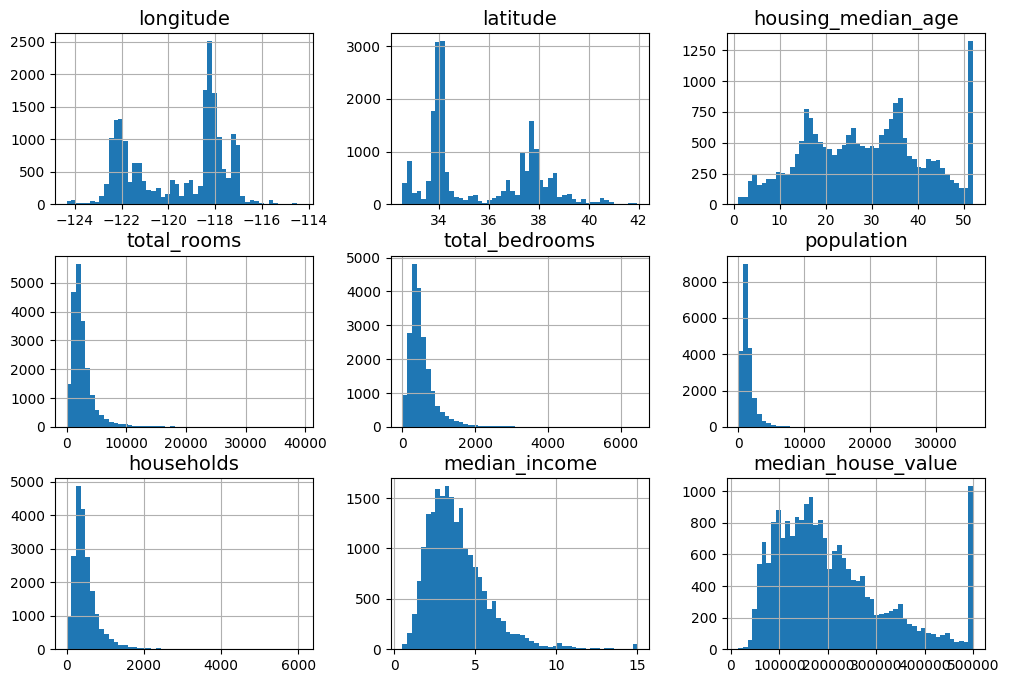

In [ ]:
# 특징의 히스토그램 생성
housing.hist(bins=50, figsize=(12, 8))
plt.show()

위 히스토그램에서 다음과 같은 내용을 분석할 수 있음:
- `median_income` 특징은 미국 달러(USD)로 표현된 것 같지 않으며, 최대/최소값이 제한되어 있음
 - 0.5보다 작은 값과 15보다 큰 값은 해당 값으로 제한됨
 - 이 숫자들은 대략 수만 달러를 나타내며, 예를 들어 3은 약 $30,000에 해당
 - 데이터가 어떻게 계산되었는지 이해하는 것이 중요함
- `housing_median_age`와 `median_house_value`도 값이 제한됨
- 여러 특징들은 서로 다른 범위를 가지고 있음
- 많은 히스토그램들이 오른쪽으로 왜곡되어 있음. 중앙값 오른쪽으로 길게 늘어나 있어 일부 머신러닝 알고리즘이 패턴을 학습하기 어렵게 만들 수 있음.


<img src="https://scikit-learn.org/0.21/_images/grid_search_workflow.png" width="550">

In [ ]:
# 테스트 세트 만들기: 데이터셋의 20% 정도(데이터셋이 매우 클 경우에는 더 적게)를 무작위로 선택
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

- 무작위 샘플링:
 - 데이터셋이 충분히 크면 일반적으로 괜찮지만, 그렇지 않으면 샘플링 편향이 생길 위험이 있음
 - 예시: 설문조사 회사에서 1,000명을 대상으로 질문할 때, 질문에 대해 인구 전체를 대표할 수 있도록 1,000명을 고르려고 노력함. 미국 인구는 51.1%가 여성이고 48.9%가 남성이므로 여성 511명, 남성 489명을 골라 설문조사를 진행
- 이는 층화 표집(stratified sampling)이라고 불리며, 인구를 층(strata)이라고 하는 동질적인 하위 그룹으로 나누고, 각 층에서 적절한 수의 인스턴스를 샘플링하여 테스트 세트가 전체 인구를 대표하도록 보장


- 전문가들과 대화한 결과, 중위소득이 주택중위가격을 예측하는 데 매우 중요한 특징임을 알게 되어 테스트 세트가 전체 데이터셋의 다양한 소득 카테고리를 대표하도록 보장하려고 함
- 중위소득이 연속적인 숫자 특징(continuous numerical feature)이므로, 먼저 소득 카테고리 특징을 만들어야 함
- 중위소득 히스토그램을 자세히 보면, 대부분의 중위소득 값은 1.5에서 6 사이에 집중되어 있음 (\$15,000–\$60,000). 일부 중위소득은 6을 넘어감.
- 각 층에 충분한 수의 인스턴스가 있어야 해당 층의 중요성에 대한 추정치가 편향되지 않음
- 다음 코드는 `pd.cut()` 함수를 사용해 소득 카테고리 특징을 다섯 개의 카테고리로 만드는 예임 (1부터 5까지 레이블이 붙음)
 - 카테고리 1은 0에서 1.5 사이 ($15,000 미만)
 - 카테고리 2는 1.5에서 3 사이

In [ ]:
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

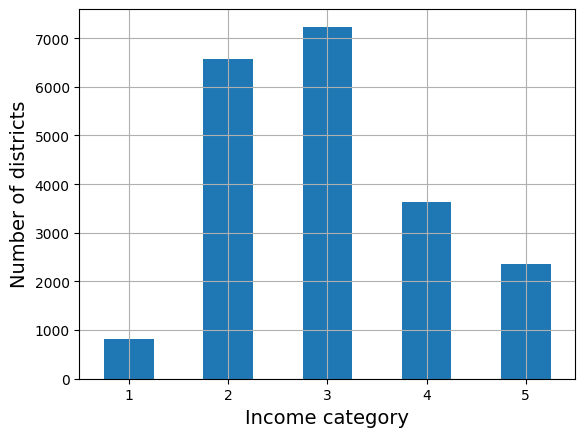

In [ ]:
# 카테고리화된 특징 시각화
housing["income_cat"].value_counts().sort_index().plot.bar(rot=0, grid=True)
plt.xlabel("Income category")
plt.ylabel("Number of districts")
plt.show()

In [ ]:
# `train_test_split()` 함수의 `stratify` 파라미터를 사용
strat_train_set, strat_test_set = train_test_split(
    housing, test_size=0.2, stratify=housing["income_cat"], random_state=42)

In [ ]:
# 예상대로 작동했는지 확인: 테스트 세트에서 소득 카테고리 비율을 확인
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

,count
income_cat,
3,0.350533
2,0.318798
4,0.176357
5,0.114341
1,0.039971


In [ ]:
# random sampling vs. stratified sampling 비교
#

def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "Overall %": income_cat_proportions(housing),
    "Stratified %": income_cat_proportions(strat_test_set),
    "Random %": income_cat_proportions(test_set),
}).sort_index()
compare_props.index.name = "Income Category"
compare_props["Strat. Error %"] = (compare_props["Stratified %"] /
                                   compare_props["Overall %"] - 1)
compare_props["Rand. Error %"] = (compare_props["Random %"] /
                                  compare_props["Overall %"] - 1)
(compare_props * 100).round(2)

,Overall %,Stratified %,Random %,Strat. Error %,Rand. Error %
Income Category,,,,,
1,3.98,4.00,4.24,0.36,6.45
2,31.88,31.88,30.74,-0.02,-3.59
3,35.06,35.05,34.52,-0.01,-1.53
4,17.63,17.64,18.41,0.03,4.42
5,11.44,11.43,12.09,-0.08,5.63


In [ ]:
# 더 이상 income_cat 열을 사용하지 않으므로, 해당 열을 삭제
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

## 2. 데이터 시각화

In [ ]:
# 데이터셋 복사
housing = strat_train_set.copy()

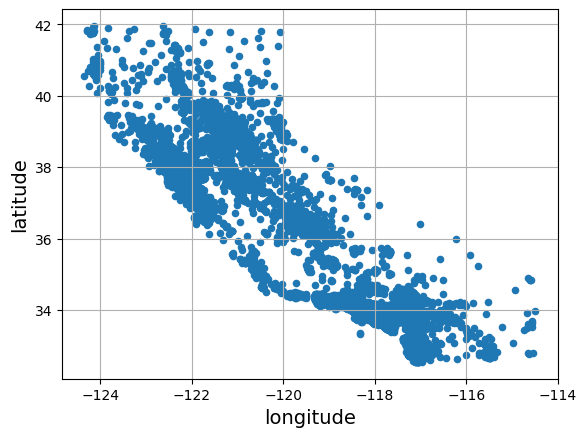

In [ ]:
# 지리적 데이터 시각화
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True)
plt.show()

- 캘리포니아 지도처럼 보이지만 그 외에는 특별한 패턴을 보기 어려움. `alpha` 옵션을 `0.2`로 설정하면 데이터 포인트가 밀집된 지역을 더 쉽게 시각화할 수 있음

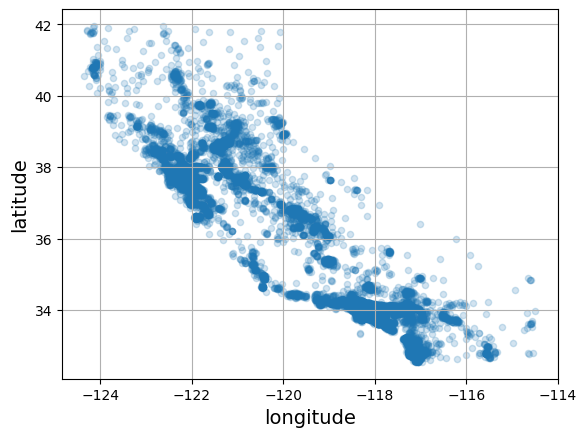

In [ ]:
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True, alpha=0.2)
plt.show()

- 캘리포니아 주의 주요 고밀도 지역이 보임.

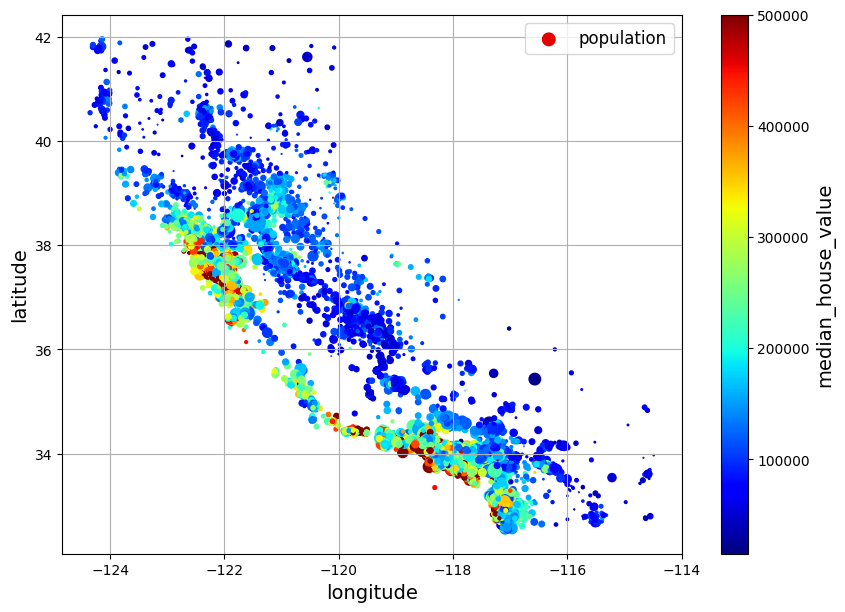

In [ ]:
# 패턴을 더 두드러지게 만들기 위해 시각화 매개변수를 추가로 조정
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True,
             s=housing["population"] / 100, label="population",
             c="median_house_value", cmap="jet", colorbar=True,
             legend=True, figsize=(10, 7))
plt.show()

- 빨간색은 비싼 지역, 파란색은 저렴한 지역을 나타내며, 큰 원은 인구가 많은 지역을 의미함
- 이 그래프는 주택 가격이 위치(예: 바다 근처)와 인구 밀도와 매우 관련이 있음을 보여줌
- 클러스터링 알고리즘을 사용하면 주요 클러스터를 감지하고, 클러스터 중심에 대한 근접성을 측정하는 새로운 특징을 추가하는 데 유용할 것임


In [ ]:
# TODO 3: 각 특징 쌍 간의 표준 상관 계수(Pearson’s r) 계산
corr_matrix = housing.corr(numeric_only=True)

In [ ]:
corr_matrix["median_house_value"].sort_values(ascending=False)

,median_house_value
median_house_value,1.000000
median_income,0.688380
total_rooms,0.137455
housing_median_age,0.102175
households,0.071426
total_bedrooms,0.054635
population,-0.020153
longitude,-0.050859
latitude,-0.139584


- 상관 계수는 -1에서 1까지의 범위를 가짐
- 1에 가까울 때는 강한 양의 상관관계를 의미하며, 예를 들어 중위소득이 올라갈 때 주택중위가격도 올라가는 경향이 있음
- -1에 가까울 때는 강한 음의 상관관계를 의미하며, 위도와 주택중위가격 간에 약한 음의 상관관계를 볼 수 있음 (즉, 북쪽으로 갈수록 가격이 약간 내려가는 경향이 있음)
- 마지막으로, 0에 가까운 계수는 선형 상관관계가 없음을 의미함

- 특징 간의 상관관계를 확인하는 또 다른 방법은 Pandas의 `scatter_matrix()` 함수를 사용하는 것임
- 이 함수는 모든 숫자형 특징을 다른 숫자형 특징들과 각각 비교하여 산점도를 그림
- 현재 11개의 숫자형 특징이 있으므로 \(11^2 = 121\)개의 그래프가 생성
- 따라서 주택중위가격과 가장 상관관계가 있어 보이는 몇 가지 특징에 집중

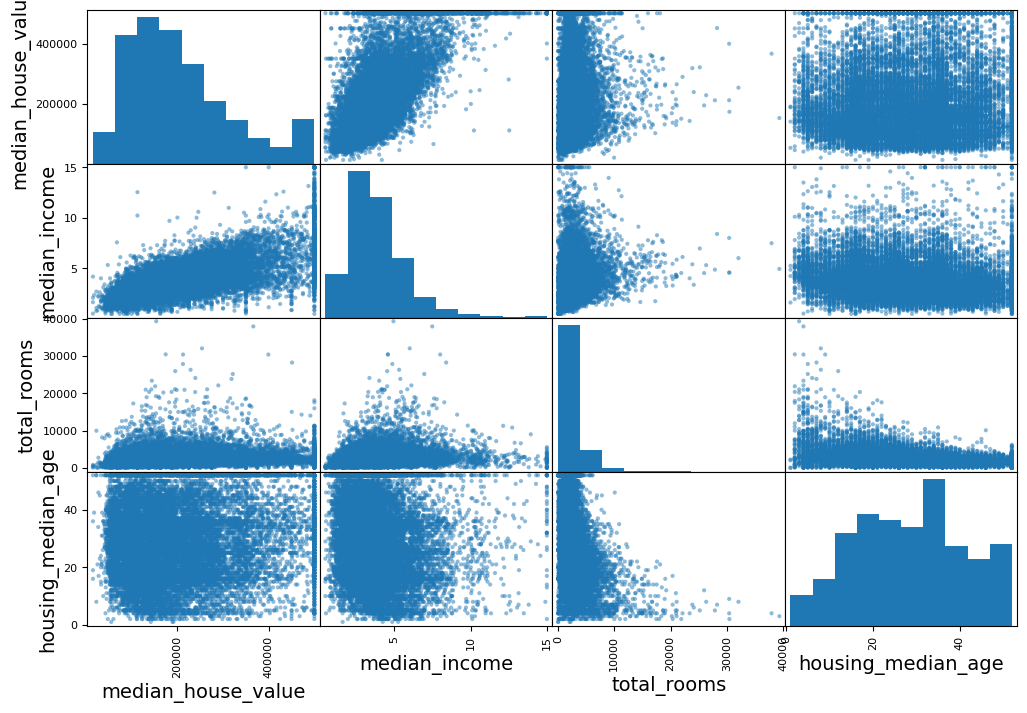

In [ ]:
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))
plt.show()

- 상관관계 산점도를 보면, 주택중위가격을 예측하는 데 가장 유망한 특징은 중위소득인 것으로 보임

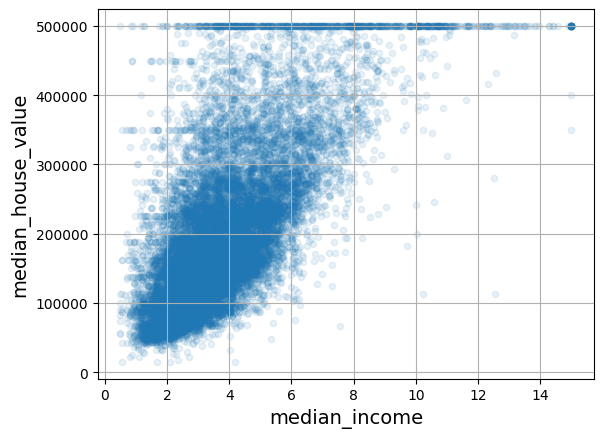

In [ ]:
# 중위소득과 주택중위가격의 산점도를 확대
housing.plot(kind="scatter", x="median_income", y="median_house_value",
             alpha=0.1, grid=True)
plt.show()

- 첫째, 상관관계가 상당히 강하다는 것을 알 수 있으며, 명확한 상승 추세가 보이고 점들이 크게 분산되지 않음
- 둘째, 이전에 언급한 \$500,000의 가격 상한선이 수평선으로 명확히 나타남
 - 덜 명확한 수평선들도 보여줌: \$450,000, \$350,000, \$280,000 주변에 각각 수평선이 존재
- 모델이 이러한 특이점을 재현하지 않도록 해당 구역을 제거하는 것을 고려할 수 있음

**새로운 특징 조합**

- 구역 내 총 방 개수는 가구 수를 모르면 그다지 유용하지 않음. 실제로 필요한 것은 가구당 방 개수임.
- 총 침실 개수만으로는 유용하지 않으며, 방 개수와 비교하는 것이 더 유용할 것임
- 가구당 인구 수도 의미있는 특징 조합일 수 있음

In [ ]:
housing["rooms_per_house"] = housing["total_rooms"] / housing["households"]
housing["bedrooms_ratio"] = housing["total_bedrooms"] / housing["total_rooms"]
housing["people_per_house"] = housing["population"] / housing["households"]

In [ ]:
# 새로운 특징의 상관계수 출력:
corr_matrix = housing.corr(numeric_only=True)
corr_matrix["median_house_value"].sort_values(ascending=False)

,median_house_value
median_house_value,1.000000
median_income,0.688380
rooms_per_house,0.143663
total_rooms,0.137455
housing_median_age,0.102175
households,0.071426
total_bedrooms,0.054635
population,-0.020153
people_per_house,-0.038224
longitude,-0.050859


- 새로 만든 `bedrooms_ratio` 특징은 방 개수나 침실 개수보다 주택중위가격과 더 높은 상관관계를 보임
- 침실/방 비율이 낮을수록 주택 가격이 더 비싼 경향이 있음
- 가구당 방 개수도 구역 내 총 방 개수보다 더 유의미한 정보를 제공함
- 집이 클수록 더 비싸다는 사실을 확인할 수 있음

## 3. 데이터 준비와 전처리

In [ ]:
# TODO 4: 데이터 복사본 생성 및 예측 레이블 분리
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

In [ ]:
# 결측치 확인
null_rows_idx = housing.isnull().any(axis=1)
housing.loc[null_rows_idx].head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
14452,-120.67,40.50,15.0,5343.0,NaN,2503.0,902.0,3.5962,INLAND
18217,-117.96,34.03,35.0,2093.0,NaN,1755.0,403.0,3.4115,<1H OCEAN
11889,-118.05,34.04,33.0,1348.0,NaN,1098.0,257.0,4.2917,<1H OCEAN
20325,-118.88,34.17,15.0,4260.0,NaN,1701.0,669.0,5.1033,<1H OCEAN
14360,-117.87,33.62,8.0,1266.0,NaN,375.0,183.0,9.8020,<1H OCEAN


- 대부분의 머신러닝 알고리즘은 누락된 특징이 있는 데이터를 처리할 수 없으므로 이를 해결해야 함
- 예를 들어, 이전에 `total_bedrooms` 특징에 일부 누락된 값이 있음을 발견함. 이를 처리하는 방법들은 다음과 같음:
  - Option 1: 해당 구역(row)을 제거
  - Option 2: 해당 특징(column)을 전체적으로 제거
  - Option 3: 누락된 값을 특정 값(0, 평균, 중앙값 등)으로 설정. 이를 결측값 대체(imputation)라고 부름
- 이러한 작업은 Pandas DataFrame의 `dropna()`, `drop()`, `fillna()` 메서드를 사용하여 쉽게 수행할 수 있음

```python
housing.dropna(subset=["total_bedrooms"], inplace=True) # option 1

housing.drop("total_bedrooms", axis=1) # option 2

median = housing["total_bedrooms"].median() # option 3
housing["total_bedrooms"].fillna(median, inplace=True)
```





- 가장 덜 파괴적인 옵션 3 선택
- 이전의 Pandas 코드 대신, Scikit-Learn의 `SimpleImputer` 클래스를 사용
 - `SimpleImputer`의 장점은 각 특징의 중앙값을 저장한다는 점임
- 이를 통해 훈련 세트뿐만 아니라 검증 세트, 테스트 세트, 그리고 모델에 새로 입력되는 데이터에도 결측값을 대체할 수 있음

In [ ]:
# `SimpleImputer` 인스턴스를 생성하고, 각 특징의 결측값을 해당 특징의 중앙값으로 대체하도록 지정

from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median") # 평균('mean')이나 최빈값('most_frequent')로도 설정 가능

# "median"을 사용하기 위해 수치 특성만을 분리(ocean_proximity 같은 텍스트 특성에서는 계산할 수 없음):
housing_num = housing.select_dtypes(include=[np.number])
imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [ ]:
# imputer는 각 특징의 중앙값을 계산하여 결과를 statistics_ 변수에 저장:
imputer.statistics_

array([-118.51,   34.26,   29.  , 2125.  ,  434.  , 1167.  ,  408.  ,
          3.54])

In [ ]:
# 각 특성의 중앙값을 수동으로 계산한 것과 같은지 확인:
housing_num.median().values

array([-118.51,   34.26,   29.  , 2125.  ,  434.  , 1167.  ,  408.  ,
          3.54])

In [ ]:
# 모든 숫자형 특징에 imputer를 적용:
X = imputer.transform(housing_num)

In [ ]:
# X를 DataFrame으로 변환하고, housing_num에서 열 이름과 인덱스를 복원:
housing_tr = pd.DataFrame(X, columns=housing_num.columns,
                          index=housing_num.index)

In [ ]:
# 이전에 결측값이 존재했던 total_bedrooms 특징에 값이 채워진 것을 확인:
housing_tr.loc[null_rows_idx].head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
14452,-120.67,40.50,15.0,5343.0,434.0,2503.0,902.0,3.5962
18217,-117.96,34.03,35.0,2093.0,434.0,1755.0,403.0,3.4115
11889,-118.05,34.04,33.0,1348.0,434.0,1098.0,257.0,4.2917
20325,-118.88,34.17,15.0,4260.0,434.0,1701.0,669.0,5.1033
14360,-117.87,33.62,8.0,1266.0,434.0,375.0,183.0,9.8020


In [ ]:
# 데이터셋의 유일한 범주형 입력 특성인 ocean_proximity을 전처리하기 위해 범주 확인:
housing_cat = housing[["ocean_proximity"]]
housing_cat.head(8)

,ocean_proximity
13096,NEAR BAY
14973,<1H OCEAN
3785,INLAND
14689,INLAND
20507,NEAR OCEAN
1286,INLAND
18078,<1H OCEAN
4396,NEAR BAY


**원핫 인코딩(one-hot encoding)**
- 각 카테고리마다 하나의 이진 특징이 되도록 변환
- 하나의 특징만 1이고 나머지는 0인 방식
 - 예를 들어, 카테고리가 `"<1H OCEAN"`일 때 해당 특징은 1로 설정되고, 그렇지 않을 경우 0이 됨
 - 또 다른 특징은 카테고리가 `"INLAND"`일 때 1로 설정되고, 그렇지 않으면 0으로 설정됨
- 새로 생성된 특징들을 더미 변수(dummy variable)이라고도 함

In [ ]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder(sparse_output=False)
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

array([[0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.]])

In [ ]:
# 인코더의 categories_ 인스턴스 변수를 사용하여 카테고리 목록 출력
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [ ]:
# Pandas의 get_dummies() 함수 사용하여 원핫 인코딩 가능
df_test = pd.DataFrame({"ocean_proximity": ["INLAND", "NEAR BAY"]})
pd.get_dummies(df_test)

,ocean_proximity_INLAND,ocean_proximity_NEAR BAY
0,True,False
1,False,True


- Pandas의 `get_dummies()`와는 달리 `OneHotEncoder`은 학습한 카테고리를 기억하여 모델이 실제로 배포될 때 훈련 중 사용한 것과 정확히 같은 특징을 입력받을 수 있게 함.
- `cat_encoder`를 사용해 같은 `df_test`를 변환(`transform()`, `fit_transform()`이 아님)할 때, 어떤 출력이 나오는지 확인해보면 이 차이를 알 수 있음

In [ ]:
cat_encoder.transform(df_test)

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

- `get_dummies()`는 두 개의 카테고리만 보고 두 개의 열을 출력
- `OneHotEncoder`는 학습한 각 카테고리에 대해 하나씩, 정확한 순서로 열을 출력

In [ ]:
# 만약 훈련 데이터에 포함되지 않은 카테고리 (예: "<2H OCEAN")가 포함된 경우, `get_dummies()`은 해당 입력으로만 원핫인코딩 생성
df_test_unknown = pd.DataFrame({"ocean_proximity": ["<2H OCEAN", "ISLAND"]})
pd.get_dummies(df_test_unknown)

,ocean_proximity_<2H OCEAN,ocean_proximity_ISLAND
0,True,False
1,False,True


In [ ]:
# OneHotEncoder는 알 수 없는 카테고리를 감지하고 예외를 발생시킴
# 원한다면 handle_unknown 하이퍼파라미터를 "ignore"로 설정할 수 있으며, 이 경우 알 수 없는 카테고리를 0으로만 나타냄:
cat_encoder.handle_unknown = "ignore"
cat_encoder.transform(df_test_unknown)

array([[0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.]])

**특징 스케일링(Feature Scaling)**

방법 1: Min-max scaling

- Min-max scaling은 가장 간단한 방법으로 정규화(normalization)라고도 불림
- 공식: $$x'=\frac{x-min(x)}{max(x)-min(x)}$$
- Scikit-learn의 `MinMaxScaler` 사용
 - `feature_range` 하이퍼파라미터를 통해 범위를 변경할 수 있으며, 특정 상황에서 0-1 범위가 아닌 값이 필요할 경우(예: 신경망은 평균이 0인 입력값에서 더 잘 동작하기 때문에 -1에서 1 범위가 더 선호됨) 이를 조정할 수 있음

In [ ]:
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler(feature_range=(-1, 1))
housing_num_min_max_scaled = min_max_scaler.fit_transform(housing_num)

방법 2: 표준화(Standardization)

- 표준화(Standardization)는 평균값을 빼서 평균이 0인 값을 만들고, 그 후에 표준 편차로 나누어 표준 편차가 1이 되도록 조정
 - Min-max scaling과 달리, 표준화는 값을 특정 범위로 제한하지 않음
- 표준화는 이상치에 덜 영향을 받음
 - 예를 들어, 범위가 0에서 15인 중위소득이 실수로 100으로 기록되었다고 가정할때, 0에서 1 사이로 min-max scaling을 하면 이 이상치는 1로 매핑되고, 다른 값들은 0에서 0.15로 압축됨
 - 반면, 표준화는 이런 이상치에 큰 영향을 받지 않음
- Scikit-Learn의 `StandardScaler` 사용

In [ ]:
# TODO 5:
from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()
housing_num_std_scaled = std_scaler.fit_transform(housing_num)




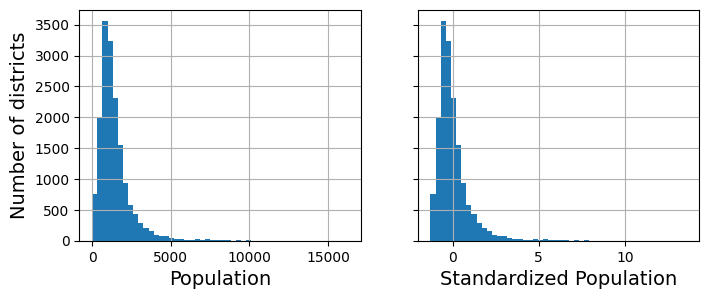

In [ ]:
# 표준화된 population 특징 시각화:
housing_num_scaled = pd.DataFrame(data=housing_num_std_scaled, columns=housing_num.columns)

fig, axs = plt.subplots(1, 2, figsize=(8, 3), sharey=True)
housing["population"].hist(ax=axs[0], bins=50)
housing_num_scaled["population"].hist(ax=axs[1], bins=50)
axs[0].set_xlabel("Population")
axs[1].set_xlabel("Standardized Population")
axs[0].set_ylabel("Number of districts")
plt.show()

**롱테일 분포 변환**

- 특정 특징의 분포가 롱테일 분포를 가질 때 **최소-최대 스케일링**과 **표준화**는 대부분의 값을 작은 범위로 압축하게 됨 $\rightarrow$ 학습이 원활하게 이루어지지 않을 수 있음.
- 따라서 특징을 스케일링하기 전에 롱테일 분포를 줄이기 위한 변환을 먼저 적용하고, 가능하다면 분포를 대략 대칭적으로 만드는 것이 좋음
 - 예를 들어, 오른쪽으로 롱테일 분포를 가진 양의 특징의 경우, 이 특징을 제곱근으로 변환하거나 0과 1 사이의 값으로 거듭제곱하는 것이 일반적인 방법임
- 멱법칙 분포(power law distribution)의 경우, 로그 변환이 도움이 될 수 있음

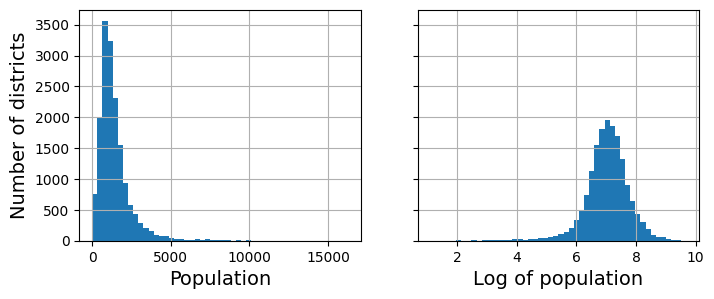

In [ ]:
# 인구 특징에 로그를 적용했을 때 얼마나 개선되는지 확인, 가우시안 분포에 가까워짐:
fig, axs = plt.subplots(1, 2, figsize=(8, 3), sharey=True)
housing["population"].hist(ax=axs[0], bins=50)
housing["population"].apply(np.log).hist(ax=axs[1], bins=50)
axs[0].set_xlabel("Population")
axs[1].set_xlabel("Log of population")
axs[0].set_ylabel("Number of districts")
plt.show()

**다봉분포(multimodal distribution) 변환**

방법 1: 구간화
- 어떤 특징이 다봉분포(서로 다른 두 개 이상의 최빈값(modes)을 갖는 연속확률분포)를 가질 때 구간화(binning)하는 것이 유용할 수 있음
- 각 bin을 ordinal 숫자 값이 아닌 범주형 값으로 취급하는 것이 중요:
 - 이 방법을 사용하면 회귀모델이 이 특성의 서로 다른 범위에 대해 서로 다른 규칙을 더 쉽게 학습할 수 있음
 - 예를 들어, 집이 오래될수록 가격이 낮다고 생각할 수 있지만 특정 연도에 지어진 주택의 스타일이 유행이 되어 단순히 연도만으로 예측할 수 있는 것보다 더 가격이 높을 수 있음.
 - 적당한 크기의 bin을 고려하고 `OneHotEncoder`로 인코딩

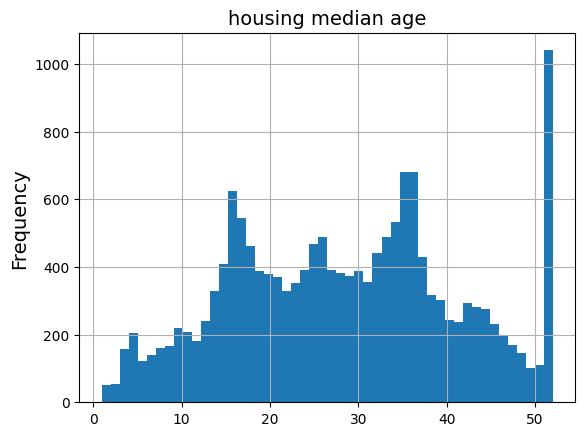

In [ ]:
# housing_median_age 특징의 다봉분포 확인:
housing["housing_median_age"].plot(kind="hist", title="housing median age", grid=True, bins=50)
plt.show()

방법 2: RBF(radial basis function)

- 모델이 다봉 분포인 `housing_median_age` 특징을 쉽게 이해할 수 있도록 하기 위해 분포의 각 주요 봉우리(최빈값)를 단봉 분포로 변환하고, 이를 특징으로 추가하는 것임.
 - 즉, `housing_median_age`의 분포에는 두 개의 주요 봉우리(최빈값)가 있는데, 각 최빈값에 맞는 단봉 분포를 그려 이를 특징으로 추가함 (2개의 특징이 추가됨)
 - 이 특징은 `housing_median_age`와 특정 최빈값 간의 유사성을 나타냄.
- 유사성 측정은 일반적으로 radial basis function를 사용하여 계산됨. RBF는 입력 값과 고정된 점 사이의 거리만 의존하는 함수임.
- 가장 일반적으로 사용되는 RBF는 Gaussian RBF이며, 입력 값이 고정된 점에서 멀어질수록 출력 값이 지수적으로 감소함.
 - 예를 들어, housing age x와 35 사이의 Gaussian RBF 유사성은 식 $exp(–γ(x – 35)^2)$로 주어짐.
 - 하이퍼파라미터 γ (감마)는 x가 35에서 멀어질 때 유사성 측정이 얼마나 빠르게 감소하는지를 결정함.

 <img src=https://miro.medium.com/v2/resize:fit:640/format:webp/1*fQKhSW08gDhTiWHLlWhBcA.png>

- $X_1 = X_2$일 때, Gaussian RBF의 값은 최대 1
- 두 값 사이가 멀 때, 값은 1보다 작고 0에 가까워짐. $\rightarrow$ 유사성 낮음

- Scikit-Learn의 `rbf_kernel()` 함수를 사용하면 housing median age와 35 사이의 유사성을 측정하는 새로운 Gaussian RBF 특징을 만들 수 있음.

In [ ]:
from sklearn.metrics.pairwise import rbf_kernel

age_simil_35 = rbf_kernel(housing[["housing_median_age"]], [[35]], gamma=0.1)

- 아래 그래프는 `housing_median_age`을 함수로 하는 이 새로운 특징을 보여줌(실선).
 - 더 작은 감마 값을 사용했을 때 특징이 어떻게 보일지를 함께 보여줌.
- 차트에서 볼 수 있듯이, 새로운 연령 유사성 특징은 `housing_median_age` 분포의 급증 부근인 35에서 정점에 도달함.
- 만약 이 특정 `housing_median_age` 그룹이 낮은 가격과 잘 상관된다면, 이 새로운 특징이 도움이 될 수 있음

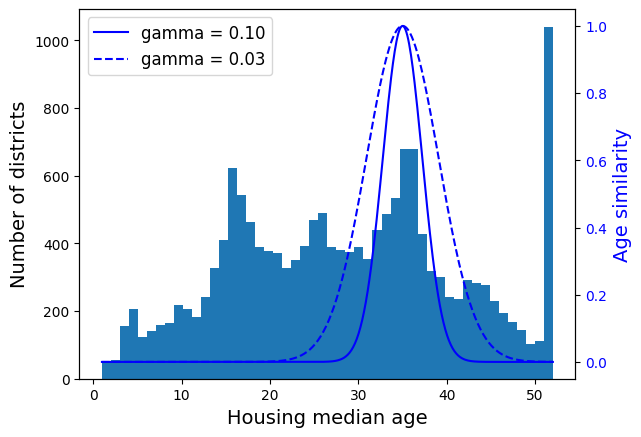

In [ ]:
ages = np.linspace(housing["housing_median_age"].min(),
                   housing["housing_median_age"].max(),
                   500).reshape(-1, 1)
gamma1 = 0.1
gamma2 = 0.03
rbf1 = rbf_kernel(ages, [[35]], gamma=gamma1)
rbf2 = rbf_kernel(ages, [[35]], gamma=gamma2)

fig, ax1 = plt.subplots()

ax1.set_xlabel("Housing median age")
ax1.set_ylabel("Number of districts")
ax1.hist(housing["housing_median_age"], bins=50)

ax2 = ax1.twinx()  # x축을 공유 하는 쌍둥이 축을 만듭니다
color = "blue"
ax2.plot(ages, rbf1, color=color, label="gamma = 0.10")
ax2.plot(ages, rbf2, color=color, label="gamma = 0.03", linestyle="--")
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylabel("Age similarity", color=color)

plt.legend(loc="upper left")
plt.show()

**특징의 커스텀 변환(Scikit-learn)**

- Scikit-Learn은 다양한 변환을 제공하지만, 맞춤형 변환, 데이터 정리, 특정 특징의 결합 등을 위해 직접 변환기를 작성해야 할 때도 있음

In [ ]:
# population 특징에 로그 변환을 적용하는 FunctionTransformer:

from sklearn.preprocessing import FunctionTransformer

log_transformer = FunctionTransformer(np.log, inverse_func=np.exp)
log_pop = log_transformer.transform(housing[["population"]])

In [ ]:
# 이전에 사용한 가우시안 RBF 유사도 측정과 동일한 계산을 수행하는 FunctionTransformer:

rbf_transformer = FunctionTransformer(rbf_kernel,
                                      kw_args=dict(Y=[[35.]], gamma=0.1))
age_simil_35 = rbf_transformer.transform(housing[["housing_median_age"]])

In [ ]:
# 입력 특징 0과 1 사이의 비율을 계산하는 FunctionTransformer:

ratio_transformer = FunctionTransformer(lambda X: X[:, [0]] / X[:, [1]])
ratio_transformer.transform(np.array([[1., 2.], [3., 4.]]))

array([[0.5 ],
       [0.75]])

**학습이 필요한 변환의 경우 클래스 작성**

- `FunctionTransformer`는 매우 유용하지만, `fit()` 메서드에서 일부 매개변수를 학습하고 `transform()` 메서드에서 이를 사용하고 싶다면 커스텀 클래스를 작성해야 함.
- Scikit-Learn은 덕 타이핑을 사용하므로, 이 클래스는 특정 베이스 클래스를 상속받을 필요가 없음.
 - 필요한 것은 `fit()` (`self`를 반환해야 함), `transform()`, 그리고 `fit_transform()`이라는 세 가지 메서드임.
 - `TransformerMixin`을 베이스 클래스로 추가하면 `fit_transform()`을 무료로 얻을 수 있음. 기본 구현은 그냥 `fit()`을 호출한 후 `transform()`을 호출함.
 - `BaseEstimator`를 베이스 클래스로 추가하고 생성자에서 `*args`와 `**kwargs`를 사용하지 않으면 두 가지 추가 메서드, `get_params()`와 `set_params()`도 얻게 됨.
- 이들은 자동 하이퍼파라미터 튜닝에 유용하게 사용될 수 있음.

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.cluster import KMeans

class ClusterSimilarity(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters=10, gamma=1.0, random_state=None):
        self.n_clusters = n_clusters
        self.gamma = gamma
        self.random_state = random_state

    def fit(self, X, y=None, sample_weight=None):
        # `n_init` 매개변수: 최상의 결과를 찾기 위해 반복하는 횟수를 지정
        self.kmeans_ = KMeans(self.n_clusters, n_init=10, random_state=self.random_state)
        self.kmeans_.fit(X, sample_weight=sample_weight)
        return self  # 항상 self를 반환

    def transform(self, X):
        return rbf_kernel(X, self.kmeans_.cluster_centers_, gamma=self.gamma)

    def get_feature_names_out(self, names=None):
        return [f"클러스터 {i} 유사도" for i in range(self.n_clusters)]

In [ ]:
cluster_simil = ClusterSimilarity(n_clusters=10, gamma=1., random_state=42)
similarities = cluster_simil.fit_transform(housing[["latitude", "longitude"]],
                                           sample_weight=housing_labels)

- 이 코드는 `ClusterSimilarity` 변환기를 생성하며, 클러스터 수를 10으로 설정함.
- 그런 다음, 훈련 데이터의 각 구역에 대한 위도와 경도를 사용하여 `fit_transform()`을 호출하며, 각 구역을 주택중위가격으로 가중치를 적용함.
- 변환기는 k-means를 사용하여 클러스터를 찾은 다음, 각 구역과 10개의 클러스터 중심 간의 Gaussian RBF 유사성을 측정함.
- 그 결과는 각 구역당 하나의 행과 클러스터당 하나의 열을 가지는 행렬임.

In [ ]:
# 첫 세 개의 행을 소수점 둘째 자리까지 반올림하여 확인:
similarities[:3].round(2)

array([[0.08, 0.  , 0.6 , 0.  , 0.  , 0.99, 0.  , 0.  , 0.  , 0.14],
       [0.  , 0.99, 0.  , 0.04, 0.  , 0.  , 0.11, 0.  , 0.63, 0.  ],
       [0.44, 0.  , 0.3 , 0.  , 0.  , 0.7 , 0.  , 0.01, 0.  , 0.29]])

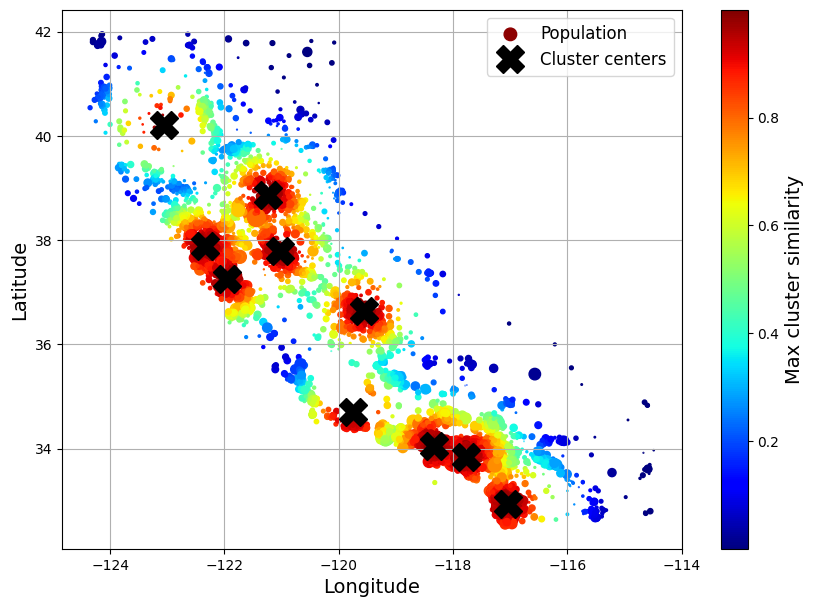

In [ ]:
# 클러스터 시각화:
housing_renamed = housing.rename(columns={
    "latitude": "Latitude", "longitude": "Longitude",
    "population": "Population",
    "median_house_value": "Median house value (ᴜsᴅ)"})
housing_renamed["Max cluster similarity"] = similarities.max(axis=1)

housing_renamed.plot(kind="scatter", x="Longitude", y="Latitude", grid=True,
                     s=housing_renamed["Population"] / 100, label="Population",
                     c="Max cluster similarity",
                     cmap="jet", colorbar=True,
                     legend=True, sharex=False, figsize=(10, 7))
plt.plot(cluster_simil.kmeans_.cluster_centers_[:, 1],
         cluster_simil.kmeans_.cluster_centers_[:, 0],
         linestyle="", color="black", marker="X", markersize=20,
         label="Cluster centers")
plt.legend(loc="upper right")
plt.show()

- 위 그래프는 k-means에 의해 발견된 10개의 클러스터 중심을 보여줌.
- 구역들은 가장 가까운 클러스터 중심과의 지리적 유사성에 따라 색으로 표시됨.
- 대부분의 클러스터는 인구 밀집 지역과 주택 가격이 높은 지역에 위치해 있음을 알 수 있음.

**Scikit-learn의 파이프라인**

- 올바른 순서로 실행되어야 하는 많은 데이터 변환 단계를 처리할 수 있도록 Scikit-Learn은 `Pipeline` 클래스를 제공함.
- 아래는 숫자형 특징에 대한 파이프라인으로, 입력 특징을 먼저 imputation한 후 스케일링하는 과정을 보여줌.

In [ ]:
from sklearn.pipeline import Pipeline

num_pipeline = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("standardize", StandardScaler()),
])

- `Pipeline` 생성자는 이름/estimator 쌍(튜플)의 리스트를 받아 변환 단계의 순서를 정의함.
 - 이름은 중복되지 않고 이중 밑줄(`__`)이 포함되지 않으면 무엇이든 상관없음.
 - 이름들은 하이퍼파라미터 튜닝을 때 유용하게 사용됨.

In [ ]:
# 변환 단계들에 이름을 붙이고 싶지 않다면, make_pipeline() 함수를 사용:
from sklearn.pipeline import make_pipeline

num_pipeline = make_pipeline(SimpleImputer(strategy="median"), StandardScaler())

In [ ]:
# 파이프라인의 fit_transform() 메서드를 호출하고, 출력의 첫 두 개 행을 소수점 둘째 자리까지 반올림하여 확인:
housing_num_prepared = num_pipeline.fit_transform(housing_num)
housing_num_prepared[:2].round(2)

array([[-1.42,  1.01,  1.86,  0.31,  1.37,  0.14,  1.39, -0.94],
       [ 0.6 , -0.7 ,  0.91, -0.31, -0.44, -0.69, -0.37,  1.17]])

In [ ]:
# 깔끔한 DataFrame을 얻고 싶다면 파이프라인의 get_feature_names_out() 메서드를 사용할 수 있음:
df_housing_num_prepared = pd.DataFrame(
    housing_num_prepared, columns=num_pipeline.get_feature_names_out(),
    index=housing_num.index)

- 지금까지 범주형/숫자형 특징을 따로 처리했으나, 모든 특징을 한번에 처리하고 각 열에 적절한 변환을 적용할 수 있는 하나의 변환기를 사용하는 것이 더 편리할 수 있음.
- 이를 위해 `ColumnTransformer` 사용

In [ ]:
# 숫자형 속성에 num_pipeline을, 범주형 속성에 cat_pipeline을 적용

from sklearn.compose import ColumnTransformer

# 숫자형과 범주형 열 이름의 리스트를 정의
num_attribs = ["longitude", "latitude", "housing_median_age", "total_rooms",
               "total_bedrooms", "population", "households", "median_income"]
cat_attribs = ["ocean_proximity"]

# 범주형 속성에 대한 간단한 파이프라인
cat_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore"))

preprocessing = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", cat_pipeline, cat_attribs),
])

- 데이터의 특징이 많은 경우에 모든 열 이름을 나열하는 것이 오래걸릴 수 있으므로, Scikit-Learn은 `make_column_selector()` 함수를 제공함.
 - 이 함수는 주어진 유형(예: 숫자형 또는 범주형)의 모든 특징을 자동으로 선택할 수 있는 selector function를 반환함.
 - 이 선택자 함수를 열 이름이나 인덱스 대신 `ColumnTransformer`에 전달할 수 있음.
- 또한 변환 단계 이름을 지정하고 싶지 않다면, `make_column_transformer()`를 사용할 수 있음. 이 함수는 `make_pipeline()`처럼 자동으로 이름을 선택함.
 - 예를 들어, 아래 코드는 이전과 동일한 `ColumnTransformer`를 생성하지만, 변환 단계 이름은 "num"과 "cat" 대신 자동으로 "pipeline-1"과 "pipeline-2"로 지정됨.

In [ ]:
from sklearn.compose import make_column_selector, make_column_transformer

preprocessing = make_column_transformer(
    (num_pipeline, make_column_selector(dtype_include=np.number)),
    (cat_pipeline, make_column_selector(dtype_include=object)),
)

# ColumnTransformer를 데이터에 적용:
housing_prepared = preprocessing.fit_transform(housing)

In [ ]:
# 전체 전처리 pipeline:
def column_ratio(X):
    return X[:, [0]] / X[:, [1]]

def ratio_name(function_transformer, feature_names_in):
    return ["ratio"]  # get_feature_names_out에 사용

def ratio_pipeline():
    return make_pipeline(
        SimpleImputer(strategy="median"),
        FunctionTransformer(column_ratio, feature_names_out=ratio_name),
        StandardScaler())

log_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    FunctionTransformer(np.log, feature_names_out="one-to-one"),
    StandardScaler())
cluster_simil = ClusterSimilarity(n_clusters=10, gamma=1., random_state=42)
default_num_pipeline = make_pipeline(SimpleImputer(strategy="median"),
                                     StandardScaler())
preprocessing = ColumnTransformer([
        ("bedrooms", ratio_pipeline(), ["total_bedrooms", "total_rooms"]),
        ("rooms_per_house", ratio_pipeline(), ["total_rooms", "households"]),
        ("people_per_house", ratio_pipeline(), ["population", "households"]),
        ("log", log_pipeline, ["total_bedrooms", "total_rooms", "population",
                               "households", "median_income"]),
        ("geo", cluster_simil, ["latitude", "longitude"]),
        ("cat", cat_pipeline, make_column_selector(dtype_include=object)),
    ],
    remainder=default_num_pipeline)  # 남은 특성: housing_median_age

In [ ]:
housing_prepared = preprocessing.fit_transform(housing)
housing_prepared.shape

(16512, 24)

In [ ]:
housing_prepared

array([[ 1.85, -0.87, -0.33, ...,  1.  ,  0.  ,  1.86],
       [-0.51,  0.02, -0.25, ...,  0.  ,  0.  ,  0.91],
       [-0.2 , -0.04, -0.05, ...,  0.  ,  0.  ,  0.35],
       ...,
       [-0.24, -0.11,  0.16, ...,  0.  ,  1.  , -1.24],
       [ 0.26, -0.36, -0.21, ...,  0.  ,  0.  ,  0.67],
       [ 3.61, -1.32,  0.05, ...,  0.  ,  1.  ,  1.23]])

In [ ]:
preprocessing.get_feature_names_out()

array(['bedrooms__ratio', 'rooms_per_house__ratio',
       'people_per_house__ratio', 'log__total_bedrooms',
       'log__total_rooms', 'log__population', 'log__households',
       'log__median_income', 'geo__클러스터 0 유사도', 'geo__클러스터 1 유사도',
       'geo__클러스터 2 유사도', 'geo__클러스터 3 유사도', 'geo__클러스터 4 유사도',
       'geo__클러스터 5 유사도', 'geo__클러스터 6 유사도', 'geo__클러스터 7 유사도',
       'geo__클러스터 8 유사도', 'geo__클러스터 9 유사도',
       'cat__ocean_proximity_<1H OCEAN', 'cat__ocean_proximity_INLAND',
       'cat__ocean_proximity_ISLAND', 'cat__ocean_proximity_NEAR BAY',
       'cat__ocean_proximity_NEAR OCEAN', 'remainder__housing_median_age'],
      dtype=object)

## 4. 모델 선택과 훈련

In [ ]:
# TODO 6: LinearRegression 모델을 훈련하고 평가하기

from sklearn.linear_model import LinearRegression

lin_reg= make_pipeline(preprocessing, LinearRegression())
lin_reg.fit(housing, housing_labels)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x784...
                                                   'median_income']),
                                                 ('geo',
                                                  ClusterSimilarity(random_state=42),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x784cedf6eaa0>)])),
                ('linearregression', LinearRegression())])

In [ ]:
housing_predictions = lin_reg.predict(housing)
housing_predictions[:5].round(-2)  # -2 = 십의 자리에서 반올림

array([242800., 375900., 127500.,  99400., 324600.])

In [ ]:
# 실제 값과 비교:
housing_labels.iloc[:5].values

array([458300., 483800., 101700.,  96100., 361800.])

In [ ]:
# 에러 비율 계산:
error_ratios = housing_predictions[:5].round(-2) / housing_labels.iloc[:5].values - 1
print(", ".join([f"{100 * ratio:.1f}%" for ratio in error_ratios]))

-47.0%, -22.3%, 25.4%, 3.4%, -10.3%


- 첫 번째 예측은 크게 빗나갔으며(20만 달러 이상 차이), 두 개의 예측은 약 25% 오차, 두 개는 10% 미만의 오차를 보임.
- RMSE를 성능 지표로 선택했으므로, Scikit-Learn의 `mean_squared_error()` 함수와 `squared` 파라미터를 `False`로 설정하여 전체 훈련 세트에 대한 회귀 모델의 RMSE를 측정

In [ ]:
from sklearn.metrics import mean_squared_error

lin_rmse = mean_squared_error(housing_labels, housing_predictions,
                              squared=False)
lin_rmse

TypeError: got an unexpected keyword argument 'squared'

- 대부분의 구역의 주택중위가격은 12만 달러에서 26만 5천 달러 사이에 있으므로, 68,628달러의 예측 오차는 크다고 볼 수 있음.
 - 이는 훈련 데이터에 대해 모델이 과소적합(underfitting)한 예임.
 - 이러한 상황이 발생하면 특징들이 좋은 예측을 하기 위한 충분한 정보를 제공하지 않거나, 모델이 충분히 강력하지 않다는 것을 의미할 수 있음.
- 과소적합을 해결하는 주요 방법은 더 강력한 모델을 선택하거나, 더 나은 특징으로 훈련 알고리즘을 제공하거나, 모델의 제약을 줄이는 것임.
 - 이 모델은 정규화되지 않았으므로, 마지막 옵션은 제외됨.
- 먼저 더 복잡한 모델인 `DecisionTreeRegressor`을 시도하여 성능을 확인

In [ ]:
# DecisionTreeRegressor를 시도
from sklearn.tree import DecisionTreeRegressor

tree_reg = make_pipeline(preprocessing, DecisionTreeRegressor(random_state=42))
tree_reg.fit(housing, housing_labels)

In [ ]:
housing_predictions = tree_reg.predict(housing)
tree_rmse = mean_squared_error(housing_labels, housing_predictions,
                              squared=False)
tree_rmse

- 모델이 데이터를 심하게 과적합했을 가능성이 있음.
- 최종 모델이 선정되고 최종 성능 평가때까지 테스트 데이터를 사용하지 않을 것이기 때문에 k-fold CV을 사용하여 모델을 평가해볼것임.

## 5. 모델 평가와 그리드 서치

**훈련-검증-테스트 셋**

<img src="https://www.brainstobytes.com/content/images/2020/01/Sets.png" width="600">

**k-fold Cross Validation(k-fold CV, 교차 검증)**

<img src="https://scikit-learn.org/stable/_images/grid_search_cross_validation.png" width="600">

- 훈련 세트를 무작위로 5개의 겹치지 않는 폴드로 나누고, 매번 다른 폴드를 평가에 사용, 나머지 4개의 폴드를 훈련에 사용하여 결정 트리 모델을 5번 훈련하고 평가함.
- 그 결과로 5개의 평가 점수를 포함하는 배열을 얻을 수 있음.
- 10-fold CV을 수행하기도 함

In [ ]:
# 실행에 시간이 걸릴 수 있음
from sklearn.model_selection import cross_val_score

tree_rmses = -cross_val_score(tree_reg, housing, housing_labels,
                              scoring="neg_root_mean_squared_error", cv=5)

In [ ]:
pd.Series(tree_rmses).describe()

- 선형 회귀 모델과 비교해보더라도 성능이 향상되지 않았음.
- 교차 검증은 모델 성능의 추정치뿐만 아니라, 표준 편차까지 고려하여 이 추정치가 얼마나 정확한지도 측정할 수 있게 해줌.

- 마지막으로 `RandomForestRegressor` 모델을 시도
 - 랜덤 포레스트는 특징의 무작위 하위 집합에 대해 여러 결정 트리를 훈련한 후, 그들의 예측을 평균화함.
 - 이러한 여러 모델로 구성된 모델을 앙상블이라고 하며, 이는 기본 모델(이 경우 결정 트리)의 성능을 향상시킬 수 있음.

In [ ]:
# 실행에 시간이 걸릴 수 있음:
from sklearn.ensemble import RandomForestRegressor

forest_reg = make_pipeline(preprocessing,
                           RandomForestRegressor(random_state=42))
forest_rmses = -cross_val_score(forest_reg, housing, housing_labels,
                                scoring="neg_root_mean_squared_error", cv=5)

In [ ]:
pd.Series(forest_rmses).describe()

In [ ]:
# 교차 검증으로 측정한 RMSE(검증 에러)와 훈련 세트로 측정한 RMSE(훈련 에러)를 비교:

forest_reg.fit(housing, housing_labels)
housing_predictions = forest_reg.predict(housing)
forest_rmse = mean_squared_error(housing_labels, housing_predictions,
                                 squared=False)
forest_rmse

- 훈련 에러가 5-fold CV 에러 보다 훨씬 낮음. 이는 모델이 훈련 세트에 과적합되었다는 의미임.
 - 이는 결정트리의 0보다는 나아졌긴 하지만 여전히 많은 과적합이 발생하고 있음을 의미함.
 - 가능한 해결책으로는 모델을 단순화하거나, 제약을 가하거나(즉, 정규화), 더 많은 훈련 데이터를 확보하는 것임.
- 해당 모델의 하이퍼파라미터 조정 전, 다양한 머신 러닝 알고리즘의 여러 모델(예: 다양한 커널을 사용한 여러 서포트 벡터 머신, 그리고 가능하면 신경망)을 시도하여 성능 개선이 이루어지는지 탐색하는 것이 좋음.
 - 하이퍼파라미터 조정에 많은 시간을 쓰지 말고, 몇 가지(2~5개) 유망한 모델을 추리는 것이 목표임.



**그리드 서치(Grid Search)**

- 하이퍼파라미터 값을 수동으로 조정하여 최적의 조합을 찾는 것
 - 매우 번거로운 작업일 수 있으며, 많은 조합을 탐색할 시간이 부족할 수 있음.
 - Scikit-Learn의 GridSearchCV 클래스를 사용해 자동으로 탐색할 수 있음.
- GridSearchCV는 교차 검증을 사용하여 가능한 모든 하이퍼파라미터 값의 조합을 평가함.

In [ ]:
# RandomForestRegressor의 최적의 하이퍼파라미터 조합을 탐색
# 실행에 시간이 걸릴 수 있음:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV


# -----TODO 7-----
full_pipeline = Pipeline([
    ("preprocessing", preprocessing),
    ("random_forest", RandomForestRegressor(random_state=42)),
])
# ---------------

# -----TODO 8-----
param_grid = [
    {'preprocessing__geo__n_clusters': [5, 8],
     'random_forest__max_features': [4, 6]},
    {'preprocessing__geo__n_clusters': [10, 15],
     'random_forest__max_features': [6, 8]},
]

# ---------------

grid_search = GridSearchCV(full_pipeline, param_grid, cv=3,  # 3-fold CV
                           scoring='neg_root_mean_squared_error')
grid_search.fit(housing, housing_labels)


코드 설명:
- `'preprocessing__geo__n_clusters'`:
 - 문자열을 `__` 으로 나눈 후, 파이프라인에서 `preprocessing`이라는 이름의 estimator을 찾고, `preprocessing` `ColumnTransformer`을 찾음
 - 이 `ColumnTransformer`에서 `geo`라는 이름의 변환 단계를 찾아 위도와 경도 속성에 사용한 `ClusterSimilarity` 변환기를 찾음.
 - 이 변환기의 `n_clusters` 하이퍼파라미터를 찾음.
- `'random_forest__max_features'`:
 - `'random_forest'`라는 이름의 estimator의 `max_features` 하이퍼파라미터를 참조

- `param_grid`에는 두 개의 딕셔너리가 있음. 따라서 `GridSearchCV`는 먼저 첫 번째 딕셔너리에 지정된 `n_clusters`와 `max_features` 하이퍼파라미터 값의 2 × 2 = 4가지 조합을 평가함.
 - 그런 다음, 두 번째 딕셔너리에서 하이퍼파라미터 값의 2 × 2 = 4가지 조합을 시도함.
 - 따라서 그리드 검색은 총 4 + 4 = 8가지의 하이퍼파라미터 조합을 탐색하게 됨.
- 또한, 3-fold CV을 사용하고 있으므로, 각 조합당 파이프라인을 3번씩 훈련하게 됨.
 - 이는 총 8 × 3 = 24번의 훈련이 필요
- 시간이 조금 걸릴 수 있지만, 완료되면 최적의 하이퍼파라미터 조합을 다음과 같이 얻을 수 있음.

In [ ]:
# 그리드 탐색에서 테스트한 하이퍼파라미터 조합의 점수를 확인:
cv_res = pd.DataFrame(grid_search.cv_results_)
cv_res.sort_values(by="mean_test_score", ascending=False, inplace=True)

# 데이터프레임을 깔끔하게 출력하기 위한 코드:
cv_res = cv_res[["param_preprocessing__geo__n_clusters",
                 "param_random_forest__max_features", "split0_test_score",
                 "split1_test_score", "split2_test_score", "mean_test_score"]]
score_cols = ["split0", "split1", "split2", "mean_test_rmse"]
cv_res.columns = ["n_clusters", "max_features"] + score_cols
cv_res[score_cols] = -cv_res[score_cols].round().astype(np.int64)

cv_res.head()

In [ ]:
# TODO 9: 최상의 하이퍼파라미터 조합 출력
grid_search.best_params_

In [ ]:
# TODO 10: 최종모델
final_model = grid_search.best_estimator_

In [ ]:
# 최종모델의 특성 중요도
feature_importances = final_model["random_forest"].feature_importances_
feature_importances.round(2)

In [ ]:
# 중요도 점수를 내림차순으로 정렬하고, 해당하는 속성 이름과 함께 표시:
sorted(zip(feature_importances,
           final_model["preprocessing"].get_feature_names_out()),
           reverse=True)

- 이러한 정보를 바탕으로 덜 유용한 특징들을 제거해볼 수 있음.
- 예를 들어, `ocean_proximity` 범주 중에서 유용한 것은 하나뿐인 것 같으므로, 다른 범주들을 제거해 볼 수 있음.

**랜덤 서치(Random Search)**

<img src="https://images.contentstack.io/v3/assets/bltb654d1b96a72ddc4/blt500831b25ec72372/660f40c8e838c8586360f703/SPC-Blog-Hyperparameter-optimization-2.jpg">

- 그리드 서치는 이전 예시처럼 비교적 적은 조합을 탐색할 때에는 적합하지만
`RandomizedSearchCV`가 더 나은 경우가 많음. 특히 하이퍼파라미터 탐색 공간이 클 때 이점이 있음.
- 이 클래스는 `GridSearchCV`와 거의 같은 방식으로 사용할 수 있지만, 모든 가능한 조합을 시도하는 대신 고정된 횟수의 조합을 평가하며 매 반복마다 각 하이퍼파라미터의 무작위 값을 선택함.
- 랜덤 서치의 장점은 다음과 같음:
  - 일부 하이퍼파라미터가 연속적이거나 (또는 가능 값이 많은 discrete한 경우) 랜덤 서치를 1,000번 실행한다고 가정하면, 각 하이퍼파라미터에 대해 1,000개의 서로 다른 값을 탐색할 수 있음. 반면 그리드 서치는 각 하이퍼파라미터에 대해 미리 지정한 몇 가지 값만 탐색함.
  - 만약 어떤 하이퍼파라미터를 미세조정하기 위해 10개의 탐색 값을 추가하면, 그리드 서치에서는 훈련 시간이 10배 길어짐. 그러나 랜덤 서치에 추가하면 큰 차이가 나지 않음.
  - 6개의 하이퍼파라미터를 탐색해야 하고, 각각 10개의 가능한 값을 가진다면, 그리드 탐색은 모델을 백만 번 훈련해야 하지만, 랜덤 탐색은 원하는 만큼의 반복 횟수로 실행할 수 있음.

다음은 Scikit-Learn의 `RandomizedSearchCV` 사용 예시임:

```python
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {'preprocessing__geo__n_clusters': randint(low=3, high=50),
                  'random_forest__max_features': randint(low=2, high=20)}

rnd_search = RandomizedSearchCV(
    full_pipeline, param_distributions=param_distribs, n_iter=10, cv=3,
    scoring='neg_root_mean_squared_error', random_state=42)

rnd_search.fit(housing, housing_labels)
```

하이퍼파라미터를 위한 샘플링 분포 선택 방법:
- `scipy.stats.randint(a, b+1)`: a~b 사이의 이산적인 값을 가진 하이퍼파라미터. 이 범위의 모든 값은 동일한 확률을 가짐.
- `scipy.stats.uniform(a, b)`: `randint`와 비슷하지만 연속적인 파라미터에 사용.
- `scipy.stats.geom(1 / scale)`: 이산적인 값의 경우 주어진 스케일 안에서 샘플링하고 싶을 때 사용. 예를 들어 scale=1000인 경우 대부분의 샘플은 이 범주 안에 있지만 모든 샘플 중 10% 정도는 100보다 작고, 10% 정도는 2300보다 큼.
- `scipy.stats.expon(scale)`: geom의 연속적인 버전임. scale을 가장 많이 등장할 값으로 지정.

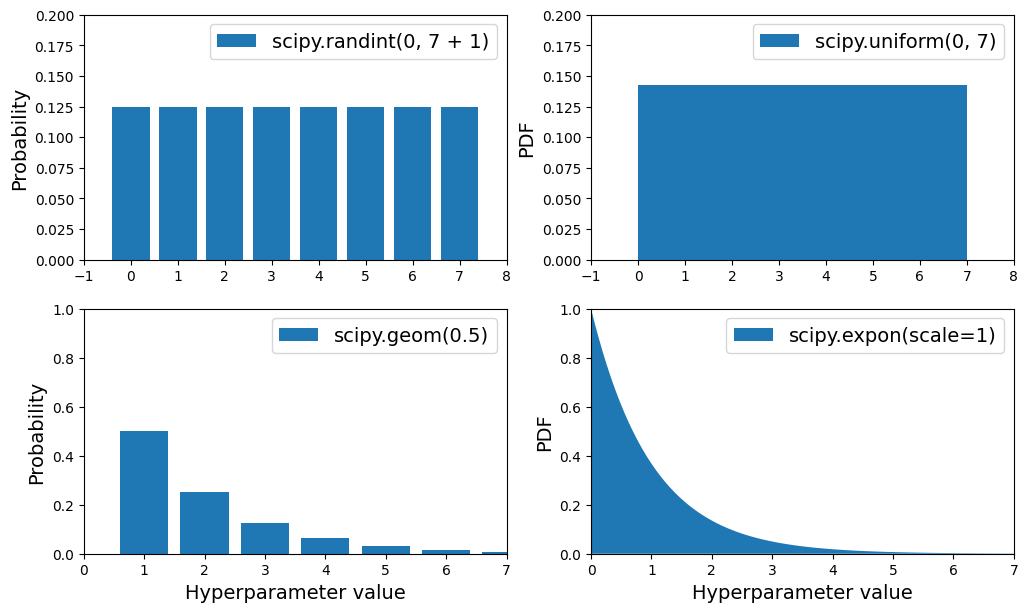

**최종 모델의 테스트 성능 평가**

- 모델을 어느 정도 조정한 후, 최종적으로 충분히 성능이 좋은 시스템을 갖추게 됨.
- 이제 최종 모델을 테스트 세트에서 평가할 준비가 되었음.
- 이 과정은 특별한 것이 없으며, 테스트 세트에서 예측 변수와 라벨을 가져온 후, final_model을 사용해 데이터를 변환하고 예측을 수행한 뒤, 이러한 예측을 평가하면 됨.

In [ ]:
X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

final_predictions = final_model.predict(X_test)

final_rmse = mean_squared_error(y_test, final_predictions, squared=False)
print(final_rmse)

- 모델을 실제로 훈련시켜 배포한다고 가정할 때, rmse 수치 하나만으로는 모델 배포를 결정하기에 충분하지 않을 수 있으며, 현재 배포된 모델보다 0.1% 더 나은 성능을 보인 상황일 수도 있음.
- 이러한 추정치의 정확성을 다음과 같이 살펴볼 수 있음:
 - `scipy.stats.t.interval()` 함수를 사용해 일반화 오류에 대한 95% 신뢰 구간을 계산할 수 있음.
 - 계산 결과, 대략 41,233와 45,514 사이의 넓은 구간을 얻었으며, 이전 점 추정치인 43,426는 이 구간의 거의 중간에 위치함을 확인할 수 있음.

In [ ]:
from scipy import stats

confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                         loc=squared_errors.mean(),
                         scale=stats.sem(squared_errors)))

- 하이퍼파라미터 튜닝을 많이 했다면, 성능이 교차 검증을 통해 측정한 것보다 약간 낮아질 수 있음.
- 이는 시스템이 검증 데이터에서 좋은 성능을 내도록 세밀하게 조정되었기 때문에, 새로운 데이터셋에서는 같은 성능을 내지 못할 가능성이 높기 때문
- 이번 예에서는 테스트 RMSE가 검증 RMSE보다 낮아서 그런 상황은 아니지만, 이런 일이 발생할 때는 테스트 세트에서 좋은 성능을 보이기 위해 하이퍼파라미터를 세밀하게 조정된 모델은 새로운 데이터에 일반화되기 어려울 가능성이 큼.

## 6. 실습 과제

제출기한: 10월 29일(화) 오후 2시 59분

유의사항:
- 제출 시 위 실습에 `# TODO:` 로 표기된 셀의 모든 내용 작성 및 실행 완료
- 실습 코드를 바탕으로 작성
- 런타임에서 위 실습 예제를 실행하지 않고 과제만을 실행하려면, 필요한 import statement와 객체들을 아래 셀에 복사하여 실행

###  1번

실습 내용을 바탕으로 아래 질문을 2-3문장으로 답하세요.

1. 레이블된 훈련 데이터셋이란 무엇인가요?
2. 모델 파라미터와 모델 하이퍼파라미터의 차이점은 무엇인가요?
3. 모델이 훈련 데이터에서는 잘 작동하지만 새로운 데이터에는 일반화되지 않는다면, 어떤 일이 발생한 것인가요? 세 가지 가능한 해결책을 작성해보세요.
4. 테스트 데이터셋란 무엇이며, 이를 왜 사용할까요?
5. 검증 데이터셋(validation dataset)의 목적은 무엇인가요?
6. 검증 데이터셋(validation dataset)과 교차 검증의 heldout set(development set이라고도 함)은 어떻게 다른가요?
7. 테스트 세트를 사용해 하이퍼파라미터를 조정하면 어떤 문제가 발생할 수 있나요?


답변:

1. 레이블된 훈련 데이터셋이란, 입력 데이터와 이에 대한 출력값(label)이 함께 제공되는 데이터 셋으로써, 해당 데이터 셋을 보면 출력값(label)은 주택 가격의 중앙값 입력 데이터는 label을 예측하기 위해 사용된 feature들이다.
2. 모델 파라미터는 모델이 학습 과정에서 데이터로부터 자동의 최적화 되는 값 Ex)가중치, 모델 하이퍼파라미터는 학습 중에 모델을 제어하기 위해 사용자가 직접 설정하는 값 Ex) knn-알고리즘에서 K(이웃의 수)
3. 3번 문장에서 언급한 현상은 과적합으로, 과적합이 일어나게된다면 훈련 데이터의 특징, 패턴에 대해서 과도하게 학습을 해서 새로운 데이터에 대한 예측 성능이 저하될 수 있는 일이 발생할 수도 있다. 이러한 과적합 현상에 대해 크게 3가지로 대처할 수 있는데 첫번째로 데이터를 더 많이 확보한다. 두번째, 간단한 알고리즘을 선택/사용 파라미터나 특징 수 줄이기/모델 정규화를 통해 모델을 단순화 마지막으로 이상치를 제거하거나 데이터를 보강해 훈련 데이터의 노이즈를 제거하는 방법이 있다.
4. 테스트 데이터셋이란 초기 데이터 셋에서 분할하여 모델이 학습하지 않은 데이터 셋으로, 최종 학습된 모델의 성능, 새로운 데이터에 대한 예측 성능을 평가하기 위해 주로 사용된다
5. 검증 데이터셋은 성능 평가와 최적의 하이퍼파라미터 조합을 선택하는 것이 목적으로 검증 데이터셋은 모델이 훈련 데이터에 과적합되지 않도록 중간 점검을 하는 식으로 사용된다.
6. 검증 데이터셋은 전체 데이터에서 일부로 분리되어 하나의 고정된 세트로써 모델 튜닝 과정에서 사용되는 반면에 교차 검증의 heldout set에서 각각의 교차 검증 과정에서 매번 다른 폴드가 검증 셋으로 사용되고 성능을 평가하는 방식으로 사용된다.
7. 테스트 데이터를 사용해 하이퍼파라미터를 조정하게 된다면 모델이 테스트데이터에 과적합될 위험이 있으며, 이는 곧 예상보다 성능이 낮은 모델을 배포할 수도 있음을 의미한다.

### 2번

[서포트 벡터 머신 회귀](https://scikit-learn.org/1.5/modules/generated/sklearn.svm.SVR.html)(`sklearn.svm.SVR`)를 `kernel=“linear”`(하이퍼파라미터 `C`를 바꿔가며)나 `kernel=“rbf”`(하이퍼파라미터 `C`와 `gamma`를 바꿔가며) 등의 다양한 하이퍼파라미터 설정으로 시도해보세요. 서포트 벡터 머신은 대용량 데이터셋에 적용하기가 쉽지 않습니다. 따라서 훈련 세트의 처음 5,000개 샘플만 사용해 모델을 훈련/평가하고 3-fold CV을 사용하세요. 최상의 SVR 모델은 무엇이며 해당 모델의 RMSE는 무엇인가요?

힌트:
- `kernel=“linear”`일때, `C`은 `300.0, 1000.0, 3000.0, 10000.0, 30000.0`
- `kernel=“rbf”`일 때, `C`은 `30.0, 100.0, 300.0, 1000.0`, `gamma`은 `0.01, 0.03, 0.1, 0.3, 1.0, 3.0`
- 훈련세트의 처음 5,000개 샘플 사용: 데이터셋에 `.iloc[:5000]` 추가


In [ ]:
# 라이브러리 모음
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
import numpy as np

# 훈련 데이터 5,000개 샘플링
housing_sample = housing.iloc[:5000]
housing_labels_sample = housing_labels.iloc[:5000]


full_pipeline = Pipeline([
    ("preprocessing", preprocessing),
    ("svr", SVR())
])
# ---------------


param_grid = [
    {'svr__kernel': ['linear'],
     'svr__C': [300.0, 1000.0, 3000.0, 10000.0, 30000.0]},
    {'svr__kernel': ['rbf'],
     'svr__C': [30.0, 100.0, 300.0, 1000.0],
     'svr__gamma': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0]}
]
# ---------------

grid_search = GridSearchCV(full_pipeline, param_grid, cv=3,
                           scoring='neg_root_mean_squared_error')
grid_search.fit(housing_sample, housing_labels_sample)

# 최상의 모델 및 RMSE
best_model = grid_search.best_estimator_
best_rmse = -grid_search.best_score_

print("최상의 SVR 모델:", best_model)
print("해당 모델의 RMSE:", best_rmse)


최상의 SVR모델은 선형 커널을 사용하며, 하이퍼파라미터 C=10000.0으로 설정된 모델
이 모델의 RMSE는 69951.46877938039

### 3번

`GridSearchCV`를 `RandomizedSearchCV`로 바꿔보세요. 2번과 마찬가지로 훈련 세트의 처음 5,000개 샘플만 사용해 모델을 훈련/평가하고 3-fold CV을 사용하세요. 찾아진 최상의 하이퍼파라미터 조합은 무엇인가요? 해당 모델의 RMSE을 2번의 성능과 `RandomForestRegressor`의 RMSE와 비교했을때 어떤가요?

힌트:
- `C`: `loguniform(20, 200_000)` [loguniform docs](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.loguniform.html)
- `gamma`: `expon(scale=1.0)`
- `RandomizedSearchCV` 파라미터: `n_iter=50`, 나머지는 예제와 같음
- `RandomizedSearchCV`을 만들 때 `verbose=2`로 지정하면 훈련 상세 과정을 출력할 수 있음.

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform, expon

# 훈련 데이터 5,000개 샘플링
housing_sample = housing.iloc[:5000]
housing_labels_sample = housing_labels.iloc[:5000]


full_pipeline = Pipeline([
    ("preprocessing", preprocessing),
    ("svr", SVR())
])
# ---------------

#(파라미터 분포)
param_distributions = [
    {'svr__kernel': ['linear'],
     'svr__C': loguniform(20, 200_000)},
    {'svr__kernel': ['rbf'],
     'svr__C': loguniform(20, 200_000),
     'svr__gamma': expon(scale=1.0)}
]
# ---------------

random_search = RandomizedSearchCV(
    full_pipeline,
    param_distributions,
    n_iter=50,
    cv=3,
    scoring='neg_root_mean_squared_error',
    verbose=2,
    random_state=42
)

# 모델 학습
random_search.fit(housing_sample, housing_labels_sample)



best_model_random = random_search.best_estimator_
best_rmse_random = -random_search.best_score_

print("모델 (RandomizedSearchCV):", best_model_random)
print("해당 모델의 RMSE (RandomizedSearchCV):", best_rmse_random)


##3. 최상의 하이퍼파라미터 조합
rbf커널을 사용했을 때
최적의 파라미터 조합:
C값 :70775.18
Gamma값 : 0.64
RMSE: 61963.28
##3-1. Random search vs Grid search
random search 방법과 Grid search 방법 각각으로 하이퍼파라미터를 탐색해보았을 때 Random search 방식으로 탐색을 했을 때 2번 문제의 방식으로 탐색했을때보다 오차가 약 7000정도 작은 것을 파악할 수 있음

### 4번

가장 중요한 특성을 선택하는 `SelectFromModel` 변환기를 `preprocessing` 파이프라인에 추가해보세요. 이전에 정의한 `preprocessing` 파이프라인 다음과 최종 회귀 모델 전에 `RandomForestRegressor` 기반의 `SelectFromModel` 변환기를 추가하는 파이프라인을 만들어보세요. 필요하다면 `SelectFromModel` [다큐멘테이션](https://scikit-learn.org/1.5/modules/generated/sklearn.feature_selection.SelectFromModel.html)을 참고하세요. `SVR` 모델의 `C`, `gamma`, `kernel` 파라미터는 2번에서 찾은 파라미터를 사용하세요. (값을 그대로 작성하지 말고, 딕셔너리의 키를 사용하여 값에 접근하세요.) 2번과 마찬가지로 훈련 세트의 처음 5,000개 샘플만 사용해 모델을 훈련/평가하고 3-fold CV을 사용하세요. 이번 문제에서는 그리드 서치나 랜덤 서치를 사용하지 않습니다. `SelectFromModel`이 파이프라인에 추가됬을때, `SVR` 모델의 3-fold CV RMSE는 이전문제와 비교했을때 어떤가요?

힌트:
- `SelectFromModel`의 `estimator`: `RandomForestRegressor`
- `RandomForestRegressor`의 `random_state`: `42`
- `RandomForestRegressor`의 `threshold`: `0.005`

예제의 다음 코드 참고:

```python
full_pipeline = Pipeline([
    ("preprocessing", preprocessing),
    ("random_forest", RandomForestRegressor(random_state=42)),
])
```

- `preprocessing` 다음에 `SelectFromModel` 변환기 추가, `random_forest` 모델은 3번의 파라미터가 설정된 `SVR`로 변경

In [ ]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score


# 훈련 데이터 5,000개 샘플링
housing_sample = housing.iloc[:5000]
housing_labels_sample = housing_labels.iloc[:5000]

# 파라미터 할당
params = {
    'C': random_search.best_estimator_.get_params()['svr__C'],
    'gamma': random_search.best_estimator_.get_params()['svr__gamma'],
    'kernel': random_search.best_estimator_.get_params()['svr__kernel']
}

# 파이프라인에 SelectFromModel 추가
full_pipeline = Pipeline([
    ("preprocessing", preprocessing),
    ("feature_selection", SelectFromModel(
        RandomForestRegressor(random_state=42),
        threshold=0.005
    )),
    ("svr", SVR(C=params['C'], gamma=params['gamma'], kernel=params['kernel']))
])

# ---------------
# 3-fold CV
scores = cross_val_score(
    full_pipeline,
    housing_sample,
    housing_labels_sample,
    cv=3,
    scoring='neg_root_mean_squared_error'
)

# RMSE
mean_rmse = -np.mean(scores)

print("3-fold CV RMSE", mean_rmse)



Feature를 선택해서 데이터를 단순화 시키는 SelectFromModel을 파이프라인에 추가함으로써 과적합을 방지하고 모델 해석 가능성을 높일 수 있다. 또한 RMSE값은 이전 3번 문제가 6196.28이 나온 것에 비해 60942.73으로 error값도 감소한 모습 확인 가능

### 5번

4번 `SelectFromModel`의 `threshold`을 랜덤 서치나 그리드 서치로 튜닝해보세요. 훈련 시간이 너무 길지 않도록 적당한 개수를 정하세요. 2번과 마찬가지로 훈련 세트의 처음 5,000개 샘플만 사용해 모델을 훈련/평가하고 3-fold CV을 사용하세요. 어떤 `threshold` 값이 찾아졌나요? 해당 값이 적용된 preprocessing 파이프라인과 3번에서 찾은 최적의 SVR 모델을 최종 모델로 선택하세요. 전체 데이터셋에 최종 모델을 훈련하고, 최종 모델의 RMSE 성능을 테스트셋에 대해 평가해보세요.

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, train_test_split


# 데이터셋
housing_sample = housing.iloc[:5000]
housing_labels_sample = housing_labels.iloc[:5000]
X_train, X_test, y_train, y_test = train_test_split(housing, housing_labels, test_size=0.2, random_state=42)

# SVR 모델 파라미터
params = {
    'C': random_search.best_estimator_.get_params()['svr__C'],
    'gamma': random_search.best_estimator_.get_params()['svr__gamma'],
    'kernel': 'rbf'  # 3번 문제 최적의 모델
}

# 랜덤 서치로  threshold 튜닝
search_param_grid = {
    "feature_selection__threshold": [0.001, 0.002, 0.005, 0.01, 0.02, 0.03, 0.05]
}

# 파이프라인 설정
full_pipeline = Pipeline([
    ("preprocessing", preprocessing),
    ("feature_selection", SelectFromModel(
        RandomForestRegressor(random_state=42)
    )),
    ("svr", SVR(C=params['C'], gamma=params['gamma'], kernel=params['kernel']))
])

# 랜덤 서치 설정
random_search = RandomizedSearchCV(
    full_pipeline,
    search_param_grid,
    n_iter=10,
    cv=3,
    scoring='neg_root_mean_squared_error',
    verbose=2,
    random_state=42
)
# 랜덤 서치
random_search.fit(housing_sample, housing_labels_sample)

# 최적 threshold
best_threshold = random_search.best_params_['feature_selection__threshold']
print("최적의 threshold 값:", best_threshold)



# 모델 훈련 파트
# 최적 threshold로 모델 훈련
final_pipeline = Pipeline([
    ("preprocessing", preprocessing),
    ("feature_selection", SelectFromModel(
        RandomForestRegressor(random_state=42),
        threshold=best_threshold
    )),
    ("svr", SVR(C=params['C'], gamma=params['gamma'], kernel=params['kernel']))
])

# 최종 모델 훈련
final_pipeline.fit(X_train, y_train)

# 테스트 데이터셋 에서 평가
test_data = final_pipeline.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test, test_data))

print("최종  테스트  RMSE :", test_rmse)



최적의 threshold 값: 0.02
RMSE : 60503.91

최적의 threshold값이 0.02로 중요도가 0.02 이상인 feature만 선택하여 모델 학습에 사용되었고, 오차인 RMSE도 60503.91로 4번에 비해서 오차가 준 모습을 보여주며 예측에 관해서 양호한 성능이라고 생각됩니다.

